In [1]:
## Code updated from RandomWalk_2020-04-01.jl

In [2]:
using Pkg;
Pkg.activate(".")

"/Users/mcfefa/Dropbox/Papers in Progress/Diversity-Score-Theory-Paper/code/Project.toml"

In [3]:
using Random
using Plots
using Statistics

┌ Info: Recompiling stale cache file /Users/mcfefa/.julia/compiled/v1.0/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184


In [4]:
## Create initial conditions
   # input: number of cells, initial clones, will randomly assign initial frequency 

function makeInitialPayoff(clones::Int64, fillPayoff::Vector, freqSel::Bool=false)
    # ... is vararg splat, takes an array of values and passes them to a function as if 1st, 2nd, 3rd
    # converts an array into arguments

    if freqSel
      payoff = fillPayoff.*rand(clones,clones)
    else
      payoff = hcat(fill(fillPayoff, (clones,1))...)
    end
    
    return payoff::Matrix
end


makeInitialPayoff (generic function with 2 methods)

In [5]:
function initialize(cellCount::Int64, numClones::Int64, fillPayoff::Vector, freqSel::Bool=false)
    
    totalCells = rand(1:numClones,cellCount); # assigning clones to each spot
    payoff = makeInitialPayoff(numClones, fillPayoff, freqSel)
    
    return (totalCells, payoff); 
end

initialize (generic function with 2 methods)

In [6]:
function calcFreq(uniqueClones::Vector{Int64}, perClone::Vector{Int64})
    cts = [count(x->x==i,perClone) for i in uniqueClones]
    return cts/sum(cts)
end

calcFreq (generic function with 1 method)

In [7]:
## Create payoff matrix -- add row/column

function makeNewClone(mtx::Matrix, parent::Int64, freqSel::Bool=false)
    
    ## add or delete depending on if new clone is added or removed from population
    # to add, make a new matrix of [n+1, n+1], loop through to fill in old matrix and add new matrix
    
    # note, should be a square matrix, x==y --- use for error handling
    
    (x,y) = size(mtx)
    newMtx = zeros(x+1,x+1)   # creates an empty matrix of zeros
    newMtx[1:x,1:x] = mtx     # fills in the original matrix
    
    if freqSel
        # FREQUENCY SELECTION
        # returns clone that will produce the new clone
        # perturb by the mean with std proportional to mean
        newMtx[x+1,1:x] = mtx[parent,:].*(1 .+ 0.01*randn(x))      
        ## fill last elements of row 
        # calculate the mean of the rows to fill in for the new clone 
        rowMean = mean(newMtx[1:x,1:x],dims=2)
        for i in 1:x
            newMtx[i,x+1] = rowMean[i]
        end
    else
        # CONSTANT SELECTION 
        newOne = mtx[parent,1]*(1+randn()) # all the same across the row, 
        newMtx[x+1,:] = fill(newOne,x+1)   # fill in constant selection for new species
        for i in 1:x
              newMtx[i,x+1] = newMtx[i,x]
        end
    end 
    
    return newMtx/maximum(newMtx)
end

makeNewClone (generic function with 2 methods)

In [8]:
## Create payoff matrix -- remove row/column

function deleteClone(mtx::Matrix{Float64}, remove::Int64)
    
    ## add or delete depending on if new clone is added or removed from population
    # to delete, just delete row and column of interest
    
    return mtx[1:end .!= remove, 1:end .!= remove]
end


deleteClone (generic function with 1 method)

In [9]:
function calcAvgFitness(payoff::Matrix{Float64}, freq::Vector{Float64})
    # multiply the frequencies by the payoff matrix to calculate the average fitness   
    # xT*A*x
    
    expectedPayoff = payoff*freq
    
    # return (transpose(freq)*Epayoff, Epayoff) 
    return (freq'*expectedPayoff, expectedPayoff) 
end

calcAvgFitness (generic function with 1 method)

In [10]:
function probReplication(payoff::Matrix{Float64}, freq::Vector{Float64}, intensity::Float64)
    
    # calculating the probability that a clone replicates
    # inputs: payoff matrix (Matrix)
    #         frequency of the clones (Vector)
    #         selection intensity (Real)
    # output: probability 
    
    (avg, expectedPayoff) = calcAvgFitness(payoff,freq);

    # Species rate of production of offspring
    probRep = exp.(intensity*(expectedPayoff)).*freq  #  .- avg
    # @show probRep

    # Compute CDF
    cs = cumsum(probRep)
    prob = cs/cs[end]
    
    # returns grouping of which proportion will be replicating when random number
    return prob
end

probReplication (generic function with 1 method)

In [11]:
function calcqD(freq::Vector{Float64}, res::Int64=1000)
  ## good default resoluion: 1000
  ## TO DO: add if q == 1 correction 

  q = exp10.(range(-2.0, stop=2.0, length=res));
  qD = sum(freq.^q', dims=1) .^ (1 ./ (1 .- q'))
  return (qD[:], q)
end

calcqD (generic function with 2 methods)

In [12]:
function runSim(initialPayoff::Vector{Float64}, totGen::Int64, cellCount::Int64, numClones::Int64, intensity::Float64, mutProb::Float64, howOftenCalcQD::Int64, resQD::Int64=1000, freqSelOn::Bool=false)
    
    # inputs: 
    #   initialPayoff::Vector{Float64} - fill vector 
    #   totGen::Int64 - number of generations to loop over
    #   cellCount::Int64 - total number of cells/total population size
    #   numClones::Int64 - number of distinct clones
    #   intensity::Float64 - selection intensity
    #   mutProb:: Float64 - probability a clone mutates 
    #   delay::Int64 - after delay steps, start calculating qD  !!!! TO DO !!!!
    #   howOftenCalcQD::Int64 - calculate qD every howOftenCalcQD timesteps
    #   resQD::Int64 - resolution at which qD is calculated, defaults to 1000 
    
    # Create the initial payoff matrix, based on cellCount & numClones
    # initialize the initial conditions
    (cells, payoff) = initialize(cellCount, numClones, initialPayoff, freqSelOn);
    totClones = numClones;
    uniqueClones = Array(1:numClones)
    numClonesTrack = zeros(Int,totGen);
    numClonesTrack[1] = numClones;
    
    # create array for collecting --- ASK JAMES IF THIS CAN BE IMPROVED
    #qDarray = Array{Float64}(undef,0,resQD)
    qDarray = Vector{Float64}[]

    # @show qDarray
    #preAlloc = Int(totGen/howOftenCalcQD)

    # calculate the frequency of each clone
    freq = calcFreq(uniqueClones,cells)
    qD, qRange = calcqD(freq);
    #@show typeof(qD)
    #println("about to push")
    push!(qDarray, qD)
    #println("pushed")
    whoDied = Tuple{Int, Float64}[]
    
    for gen in 2:totGen

        # Step 1: calculate prob of each clone to be replicating
        # Step 2: find which clone replicates (random number, see who select)
        # Step 3: decide if mutate (rand num)
        # Step 4: decide how much mutates by (offspring close to num in payoff)
        #println(unique(cells))
        # generate random numbers
        #numbers = rand(2)      
        # get a cumulative probability distribution (essentially CDF)
        CDF = probReplication(payoff, freq, intensity) 
        
        #@show CDF, gen, freq

        # decide which clone replicates
        ####### FIXME ###### (When only single clone )
        # whichOneRep=1
        roll = rand()
        
        whichOneRep = []
        whichOneRepIndex = []
        try
            whichOneRepIndex = findall(y->(y>=roll),CDF)[1]
            whichOneRep = uniqueClones[whichOneRepIndex]
        catch
            @show freq, payoff, uniqueClones,CDF
            @error("what??")
        end
        
       # println("which one reps ", whichOneRep)
        #once replication occurs, does it mutated
        if (mutProb > rand())
            ## true, add to payoff matrix
            # if you mutate, update payoff, update array of cells and add new cell to total num of clones
            #payoff = makePayoff(payoff, payoff[whichOneRepIndex,1]*(1+randn()))
            #println("pre mut payoff maker")
            #payoff = makePayoff(payoff, (payoff[whichOneRepIndex,:]'*freq)*(1+randn())) 
            payoff = makeNewClone(payoff, whichOneRepIndex, freqSelOn) 
            #println("post mut payoff maker")
            numClones +=1
            totClones +=1
            #push!(cells,numClones) --> for constant population size, do not push
            whoReplacesDead = totClones
            push!(uniqueClones, whoReplacesDead)
        else
            ## false - no mutation
            whoReplacesDead = whichOneRep
        end
        
         #println("who replaces dead ", whoReplacesDead)
            
        # randomly pick who dies (randomly pick a clone, replace with new clone)
        whichCellDies = rand(1:cellCount)
        # @show whichCellDies, whoReplacesDead, cells[whichCellDies], numClones
        cells[whichCellDies] = whoReplacesDead
        
        # check to see if a clone is lost --> 0 is a lost clone
        # calculate the frequency of each clone to identify 0 clone
        freq = calcFreq(uniqueClones,cells)
        # @show freq,uniqueClones,payoff,cells,whichOneRep,CDF
        locZeros = findall(x->x==0,freq)
        # if clone died, record it in whoDied and remove from payoff
            
        if length(locZeros) > 0
            
            deadClone = locZeros[1]
            # record which clone died and its payoff
            # @show deadClone,uniqueClones[deadClone]
            push!(whoDied, (uniqueClones[deadClone], payoff[deadClone,1]))     
            
            # delete dead clone from payoff, freq, and number of clones
            payoff = deleteClone(payoff, deadClone)
            deleteat!(freq,deadClone)
            deleteat!(uniqueClones,deadClone)
            numClones -= 1

            # @show whoDied[end],freq
            
            #println("dead clone ", deadClone)
            
        end
           #println("==============") 
           numClonesTrack[gen] = numClones; 
        if gen % howOftenCalcQD == 0
          qD, _ = calcqD(freq);
          #println(qD)
          push!(qDarray, qD)
        end
    end
   # currently only returning first column of payoff matrix because all rows are the same
    return (numClonesTrack=numClonesTrack, totClones=totClones, freq=freq, payoff=payoff[:,1], whoDied=whoDied, qD=qDarray, q=qRange)
    
end

runSim (generic function with 3 methods)

In [13]:
    # inputs: 
    #   initialPayoff::Vector{Float64} - fill vector 
    #   totGen::Int64 - number of generations to loop over
    #   cellCount::Int64 - total number of cells/total population size
    #   numClones::Int64 - number of distinct clones
    #   intensity::Float64 - selection intensity
    #   mutProb:: Float64 - probability a clone mutates 
    #   delay::Int64 - after delay steps, start calculating qD 
    #   howOftenCalcQD::Int64 - calculate qD every howOftenCalcQD timesteps
    #   resQD::Int64 - resolution at which qD is calculated, defaults to 1000 
    #   freqSelOn::Bool =

In [14]:
# outputs: (numClonesTrack=numClonesTrack, totClones=totClones, freq=freq, payoff=payoff[:,1], whoDied=whoDied, qD=qDarray, q=qRange)

In [15]:
numClones = 1;
mut = 2.0e-1;
cellCount = 1000;
initialPayoff = rand(numClones);
gen=5000;
selInt = 10.0
freqSelType = false;
resConstSel = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,100,1000,freqSelType);


(numClonesTrack = [1, 1, 2, 2, 2, 2, 3, 4, 5, 6  …  336, 336, 335, 334, 334, 334, 334, 334, 334, 333], totClones = 1051, freq = [0.004, 0.001, 0.001, 0.001, 0.001, 0.001, 0.002, 0.002, 0.001, 0.001  …  0.001, 0.001, 0.001, 0.003, 0.004, 0.001, 0.002, 0.005, 0.003, 0.01], payoff = [3.29953e-109, 2.23304e-105, 8.44743e-103, 2.48725e-101, 2.54559e-101, 1.07202e-95, 4.60837e-95, 1.91924e-94, 1.09334e-92, 1.24269e-91  …  0.00152266, 0.0110745, 0.0034449, 0.0286694, 0.0688152, 0.0511715, 0.223563, 0.41633, 0.857269, 1.0], whoDied = Tuple{Int64,Float64}[(8, 0.0987678), (36, 0.00383905), (5, -6.03713e-5), (42, 0.0217108), (11, 1.411e-6), (40, 0.0182827), (14, -4.47359e-7), (19, -1.11434e-5), (12, 3.07624e-5), (29, 0.00119619)  …  (604, 2.84681e-43), (310, 1.52251e-75), (638, 1.45637e-40), (26, 1.08012e-106), (571, -3.8572e-47), (729, -8.41333e-35), (145, 1.26543e-95), (917, 3.48787e-16), (1007, -1.07058e-7), (1018, 3.75081e-5)], qD = Array{Float64,1}[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

In [ ]:
#resFreqSel = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,100,1000,true)

In [ ]:
# plot qD curve: 
# plot(res.q,res.qD,xaxis=:log,legend=:none)
# histogram(resFreqSel.numClonesTrack[25000:end],normalize=:probability)

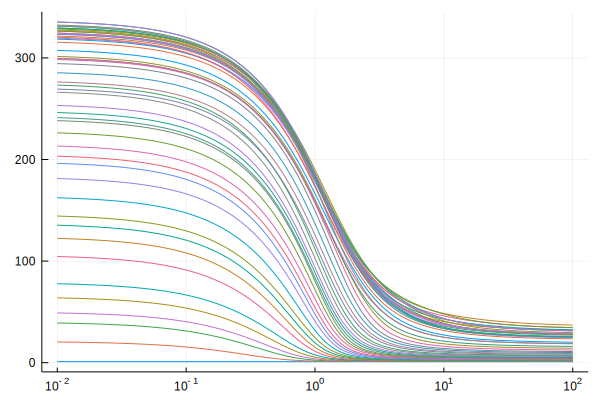

In [16]:
plot(resConstSel.q,resConstSel.qD,xaxis=:log,legend=:none)